## **Overview**

We have a training dataset $\mathcal D = \{ (x_n, y_n) \}_{n=1}^N$ must decide with which of two models $\mathrm M_1$ and $\mathrm M_2$ to fit this data.

The Bayes factor $\mathrm{BF}[\mathrm M_1:\mathrm M_2]$ between two model families $\mathrm M_1$ and $\mathrm M_2$ is given by

$$
\begin{align*}
\mathrm{BF}[\mathrm M_1:\mathrm M_2] &\equiv \frac{p(\mathrm M_1 | \mathcal D)}{p(\mathrm M_2 | \mathcal D)} \\
&= \frac{p(\mathcal D | \mathrm M_1)}{p(\mathcal D | \mathrm M_2)} \\
&= \frac{p(\{y_n\} | \{x_n\}, \mathrm M_1)}{p(\{y_n\} | \{x_n\},  \mathrm M_2)} \\
&= \frac{\mathbb E_{\theta_1 \sim p(\theta_1 | \mathrm M_1)} p(\{y_n\} | \{x_n\}, \theta_1, \mathrm M_1)}{\mathbb E_{\theta_2 \sim p(\theta_2 | \mathrm M_2)} p(\{y_n\} | \{x_n\}, \theta_2, \mathrm M_2)}.
\end{align*}
$$

This assumes $p(\mathrm M_1) = p(\mathrm M_2)$. Call $p(\mathcal D | \mathrm M)$ the *marginal prior data likelihood* of model $\mathrm M$.

**For simplicity, we are only considering Gaussian regression models, which we can fully specified a 3-tuple of weight mean, weight variance, and a basis function:** $$\textrm M = (\mu, \Sigma, \phi).$$ We define $p(w | \mathrm M) := \mathcal N(\mu, \Sigma)$ and $p(y | x, w, \mathrm M) := \mathcal N(w^\top \phi(x), \sigma^2).$ (For simplicity we assume output variance $\sigma^2$ is constant across all model families). In that case, we get a closed form solution for the marginal prior data likelihood 
$$
\begin{align*}
p(\mathcal D | \mathrm M) &= \mathbb E_{w \sim p(w | \mathrm M)} p(\{y_n\} | \{x_n\}, w, \mathrm M) \\
&= \int_w p(\{y_n\} | \{x_n\}, w, \mathrm M) \, p(w | \mathrm M) \,\mathrm d w \\
&= \int_{\mathbf w} \mathcal N(\mathbf y; \Phi \mathbf w, \sigma^2 \mathbf I) \, \mathcal N(\mathbf w; \mu, \Sigma) \,\mathrm d \mathbf w \\
&= \mathcal N(\mathbf y;\; \Phi \mu,\; \sigma^2 \mathbf I + \Phi \Sigma \Phi^\top)
\end{align*}
$$

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as ds
import copy
import torch.optim as optim
from tqdm import tqdm

In [4]:
plt.rcParams.update({
        'font.family' : 'Times',
        'font.weight' : 'bold',
        'font.size' : 9,
        'axes.titlesize' : 9,
        'axes.labelsize' : 8,
        'axes.labelweight' : 'bold',
        'xtick.labelsize' : 8,
        'ytick.labelsize' : 8,
        'legend.fontsize': 8,
        'lines.markersize': 2,
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'black',
        'legend.handlelength' : 1,
        'legend.borderpad' : 0.75,
        'patch.linewidth' : 0.75,
        'text.usetex' : True,
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{amsfonts}
''',
    })

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

greens = ['#295827', '#7bbf64', '#cbf6bb']
blues = ['#291b85', '#6653e0', '#c6befa']
reds = ['#841a1a', '#e15454', '#fabdbd']

In [5]:
OUTPUT_VAR = 0.05


def add_output_noise(x):
    return x + ds.Normal(0, OUTPUT_VAR**0.5).sample(x.shape)


class GaussianRegressionModel():
    def __init__(self, weights_mean, weights_var, basis_func):
        n_features = basis_func(torch.ones(0)).shape[-1]

        if torch.is_tensor(weights_mean):
            assert weights_mean.shape == (n_features,)
        else:
            weights_mean = weights_mean * torch.ones(n_features)

        self.weights_mean = weights_mean
        self.weights_cov = weights_var * torch.eye(n_features)
        self.basis_func = basis_func        

    def sample_model_weights(self):
        weights_prior = ds.MultivariateNormal(self.weights_mean, covariance_matrix=self.weights_cov)
        return weights_prior.sample((1,)).reshape(-1)

    def prior_log_likelihood(self, x, y):
        phi = self.basis_func(x)
        mean = phi @ self.weights_mean
        cov = (OUTPUT_VAR + (phi[:,None,:] @ self.weights_cov @ phi[:,:,None]).reshape(-1)).diag()
        return ds.MultivariateNormal(loc=mean, covariance_matrix=cov).log_prob(y)

def bayes_factor(m1, m2, x, y, log=False):
    log_bf = m1.prior_log_likelihood(x, y) - m2.prior_log_likelihood(x, y)
    return (log_bf if log else log_bf.exp()).item()

def poly_transform(x, D):
  assert x.ndim == 1, "Expected x.shape == (N,)"
  pwr = torch.arange(1, D+1)
  features = x[:,None] ** pwr
  return features

def add_bias(x):
  ones = torch.ones(x.shape[0], 1)
  return torch.hstack([ones, x])

def poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, n_terms))

def even_poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, 2*n_terms)[:, 1::2])

def odd_poly_basis(n_terms):
    return lambda x: add_bias(poly_transform(x, 2*n_terms)[:, 0::2])


## **Comparing different priors**

Recall we can specify a Gaussian regression model with the tuple $(\mu, \Sigma, \phi)$. Here, let's keep $\phi$ the same across $\mathrm M_1$ and $\mathrm M_2$ but change the prior distributions $$w_1 \sim \mathcal N(\mu_1, \Sigma_1),\quad w_2 \sim \mathcal N(\mu_2, \Sigma_2).$$ For simplicity we assume model parameters are IID (covariance matrices can be specified with a single scalar: $\Sigma = \sigma^2 I$).


In [6]:
degrees = [1, 3, 10]
means = [0, 0.1, 1, 10]
vars = [0.1, 1, 10, 100]
ns = torch.linspace(50, 100, 8)
trials = 200

100%|██████████| 3/3 [03:14<00:00, 64.80s/it]


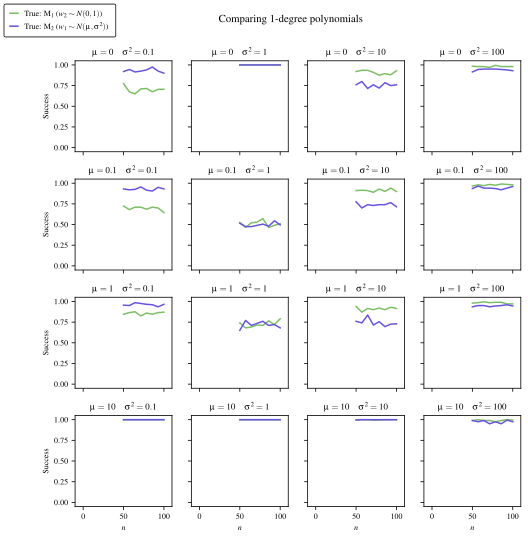

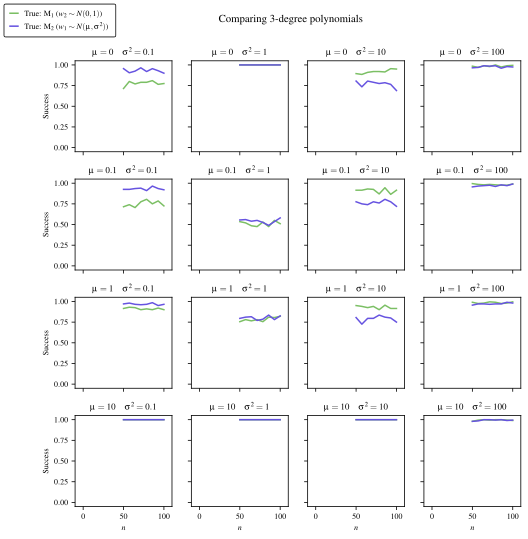

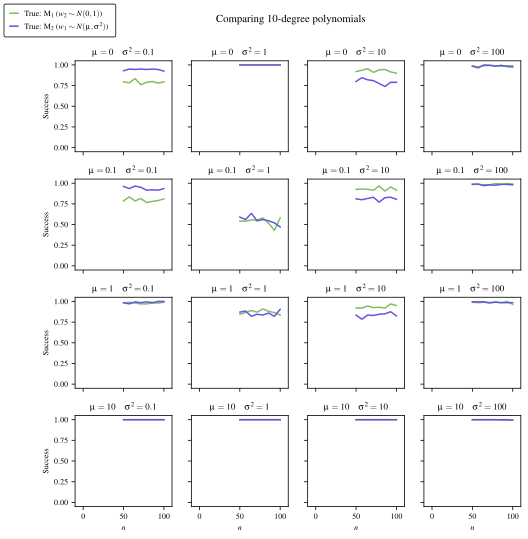

In [7]:
for d in tqdm(degrees):
  nrows, ncols = len(means), len(vars)
  fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))
  fig.subplots_adjust(hspace=0.3, top=0.9)
  fig.suptitle(f'Comparing ${d}$-degree polynomials')

  for i, mean in enumerate(means):
    for j, var in enumerate(vars):
      ax = axs[i,j]
      ax.set_ylim(-0.05, 1.05)
      ax.set_xlim(-10, ns[-1]+10)
      ax.set_ylabel('Success')
      ax.set_xlabel('$n$')
      ax.set_xticks(torch.linspace(0, ns[-1], 3))
      m1 = GaussianRegressionModel(weights_mean=0, weights_var=1, basis_func=poly_basis(d))
      m2 = GaussianRegressionModel(weights_mean=mean, weights_var=var, basis_func=poly_basis(d))

      successes = torch.zeros(2, len(ns))
      for k, n in enumerate(ns):
        n = int(n)
        for _ in range(trials):
          x_train = ds.Uniform(-1.0, 1.0).sample((n,))

          w = m1.sample_model_weights()
          phi_train = m1.basis_func(x_train)
          y_train = add_output_noise(phi_train @ w) 
          if bayes_factor(m1, m2, x_train, y_train) >= 1:
            successes[0,k] += 1

          w = m2.sample_model_weights()
          phi_train = m2.basis_func(x_train)
          y_train = add_output_noise(phi_train @ w) 
          if bayes_factor(m2, m1, x_train, y_train) >= 1:
            successes[1,k] += 1
        
      successes /= trials

      ax.set_title(rf'$\mu={mean} \quad \sigma^2={var}$')
      ax.plot(ns, successes[0], c=greens[1])
      ax.plot(ns, successes[1], c=blues[1])

  for row in axs[:-1, 1:]:
    for ax in row:
      ax.set_yticklabels([])
      ax.set_xticklabels([])
      ax.set_xlabel('')
      ax.set_ylabel('')

  for ax in axs[:-1, 0]:
    ax.set_xticklabels([])
    ax.set_xlabel('')
  
  for ax in axs[-1, 1:]:
    ax.set_yticklabels([])
    ax.set_ylabel('')


  plt.plot([-1], [-1], c=greens[1], label=r'True: $\mathrm M_1$ ($w_2 \sim N(0, 1)$)')
  plt.plot([-1], [-1], c=blues[1], label=r'True: $\mathrm M_2$ ($w_1 \sim N(\mu, \sigma^2)$)')
  fig.legend(loc='upper left')
  fig.savefig(f'output/prior-meanvar-{d}deg.pdf')


100%|██████████| 3/3 [01:21<00:00, 27.28s/it]


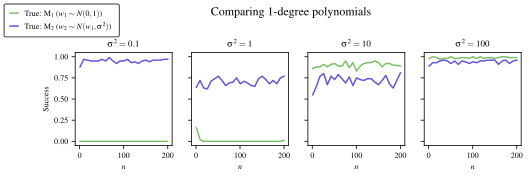

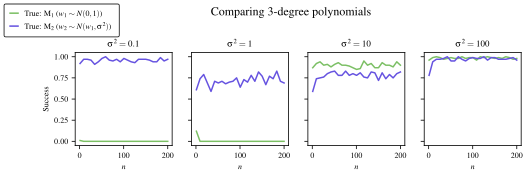

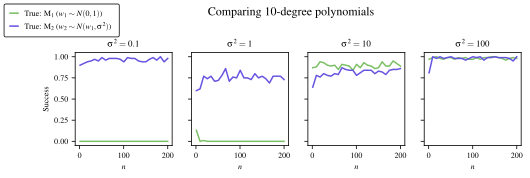

In [6]:
for d in tqdm(degrees):
  nrows, ncols = 1, len(vars)
  fig, axs = plt.subplots(nrows, ncols, figsize=(8, 2.25))
  fig.subplots_adjust(top=0.7)
  fig.suptitle(f'Comparing ${d}$-degree polynomials')

  for i, var in enumerate(vars):
    ax = axs[i]
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-10, ns[-1]+10)
    ax.set_ylabel('Success')
    ax.set_xlabel('$n$')
    ax.set_xticks(torch.linspace(0, ns[-1], 3))
    m1 = GaussianRegressionModel(weights_mean=0, weights_var=1, basis_func=poly_basis(d))

    successes = torch.zeros(2, len(ns))
    for k, n in enumerate(ns):
      n = int(n)
      for _ in range(trials):
        x_train = ds.Uniform(-1.0, 1.0).sample((n,))

        w = m1.sample_model_weights()
        m2 = GaussianRegressionModel(weights_mean=w, weights_var=var, basis_func=poly_basis(d))
        phi_train = m1.basis_func(x_train)
        y_train = add_output_noise(phi_train @ w) 
        if bayes_factor(m1, m2, x_train, y_train) >= 1:
          successes[0,k] += 1

        w = m2.sample_model_weights()
        phi_train = m2.basis_func(x_train)
        y_train = add_output_noise(phi_train @ w) 
        if bayes_factor(m2, m1, x_train, y_train) >= 1:
          successes[1,k] += 1
      
    successes /= trials

    ax.set_title(rf'$\sigma^2={var}$')
    ax.plot(ns, successes[0], c=greens[1])
    ax.plot(ns, successes[1], c=blues[1])
  
  for ax in axs[1:]:
    ax.set_yticklabels([])
    ax.set_ylabel('')


  plt.plot([-1], [-1], c=greens[1], label=r'True: $\mathrm M_1$ ($w_1 \sim N(0, 1)$)')
  plt.plot([-1], [-1], c=blues[1], label=r'True: $\mathrm M_2$ ($w_2 \sim N(w_1, \sigma^2)$)')
  fig.legend(loc='upper left')
  fig.savefig(f'output/prior-mean-{d}deg.pdf')


## **Comparing different basis functions**

Here, we keep prior distributions the same but vary the basis functions between the two families. Namely, we compare odd and even polynomial transformations for different degrees.

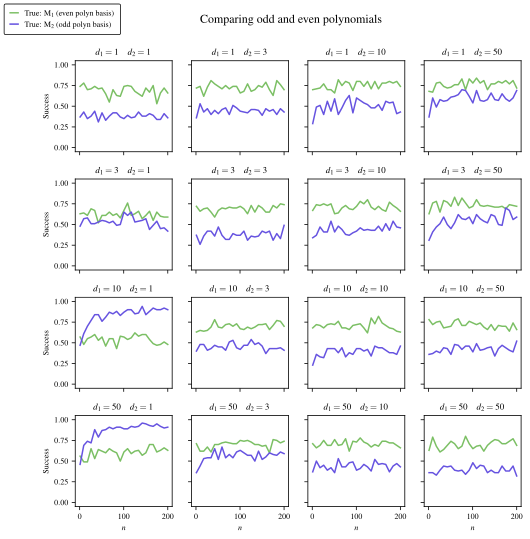

In [7]:
degrees = [1, 3, 10, 50]
var=1

nrows, ncols = len(degrees), len(degrees)
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, top=0.9)
fig.suptitle(f'Comparing odd and even polynomials')

for i, d1 in enumerate(degrees):
  for j, d2 in enumerate(degrees):
    ax = axs[i,j]
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-10, ns[-1]+10)
    ax.set_ylabel('Success')
    ax.set_xlabel('$n$')
    ax.set_xticks(torch.linspace(0, ns[-1], 3))
    m1 = GaussianRegressionModel(weights_mean=0, weights_var=var, basis_func=even_poly_basis(d1))
    m2 = GaussianRegressionModel(weights_mean=0, weights_var=var, basis_func=odd_poly_basis(d2))

    successes = torch.zeros(2, len(ns))
    for k, n in enumerate(ns):
      n = int(n)
      for _ in range(trials):
        x_train = ds.Uniform(-1.0, 1.0).sample((n,))

        w = m1.sample_model_weights()
        phi_train = m1.basis_func(x_train)
        y_train = add_output_noise(phi_train @ w) 
        if bayes_factor(m1, m2, x_train, y_train) >= 1:
          successes[0,k] += 1

        w = m2.sample_model_weights()
        phi_train = m2.basis_func(x_train)
        y_train = add_output_noise(phi_train @ w) 
        if bayes_factor(m2, m1, x_train, y_train) >= 1:
          successes[1,k] += 1
      
    successes /= trials

    ax.set_title(rf'$d_1={d1} \quad d_2={d2}$')
    ax.plot(ns, successes[0], c=greens[1])
    ax.plot(ns, successes[1], c=blues[1])

for row in axs[:-1, 1:]:
  for ax in row:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in axs[:-1, 0]:
  ax.set_xticklabels([])
  ax.set_xlabel('')

for ax in axs[-1, 1:]:
  ax.set_yticklabels([])
  ax.set_ylabel('')


plt.plot([-1], [-1], c=greens[1], label=r'True: $\mathrm M_1$ (even polyn basis)')
plt.plot([-1], [-1], c=blues[1], label=r'True: $\mathrm M_2$ (odd polyn basis)')
fig.legend(loc='upper left')
fig.savefig(f'output/bases-var{var}.pdf')


In [8]:
# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 20000

# architecture and activation
ACTIVATION = nn.LeakyReLU
DEFAULT_ACTIVATION_MODULE = nn.ReLU

torch.set_default_tensor_type(torch.DoubleTensor)


# define MLE loss
def mle_loss(basis, final_layer, x_train, y_train):
  y_pred = final_layer(basis(x_train))
  loss = torch.mean(torch.sum(torch.pow(y_pred - y_train, 2.0), -1))

  return loss, (basis, final_layer)


class FullyConnected(nn.Module):
    '''
    Fully connected neural network
    '''
    
    def __init__(
            self,
            layers,
            output_activation=False,
            activation_module=DEFAULT_ACTIVATION_MODULE,
            bias=True,
    ):
        super(FullyConnected, self).__init__()

        assert(len(layers) >= 2)
        self.layers = layers
        self.output_activation = output_activation
        self.activation_module = activation_module
        self.bias = bias

        seq = OrderedDict()
        seq['layer_0'] = nn.Linear(self.layers[0], self.layers[1], bias=bias)

        idx = 0
        for i in range(len(self.layers[1:-1])):
            seq['layer_{}_activation'.format(i)] = activation_module()

            idx = i + 1
            seq['layer_{}'.format(idx)] = nn.Linear(
                self.layers[idx], self.layers[idx + 1], bias=bias,
            )

        if output_activation:
            seq['layer_{}_activation'.format(idx + 1)] = activation_module()

        self.network = nn.Sequential(seq)

    def forward(self, x):
        return self.network(x)

    def get_weights(self):
        return torch.cat([p.view(-1) for p in self.parameters()])

    def rand_init(self, std=1.0):
        def init_weights(l):
            if isinstance(l, nn.Linear):
                torch.nn.init.normal_(l.weight, mean=0.0, std=std)                
                if self.bias:
                    torch.nn.init.normal_(l.bias, mean=0.0, std=std)

        self.network.apply(init_weights)            



def train_objective(params, loss_fn, lr=0.01, l2=0.0, epochs=5000):
    '''
    Optimizes 'loss_fn' with respect to 'params'
    'loss_fn' must take no arguments, and must return a tuple of two:
    the value of the loss, and the model. 
    '''
    
    best_model = None
    min_loss = float('inf')

    optimizer = optim.Adam(params, lr=lr, weight_decay=l2)
    try:
        for epoch in range(epochs):
            optimizer.zero_grad()

            # save loss and model if loss is the smallest observed so far
            loss, model = loss_fn()
            if loss.item() < min_loss:
                min_loss = loss.item()
                best_model = copy.deepcopy(model)
        
            loss.backward()
            optimizer.step()
        
    except KeyboardInterrupt:
        print('Interrupted...')

    return best_model, min_loss

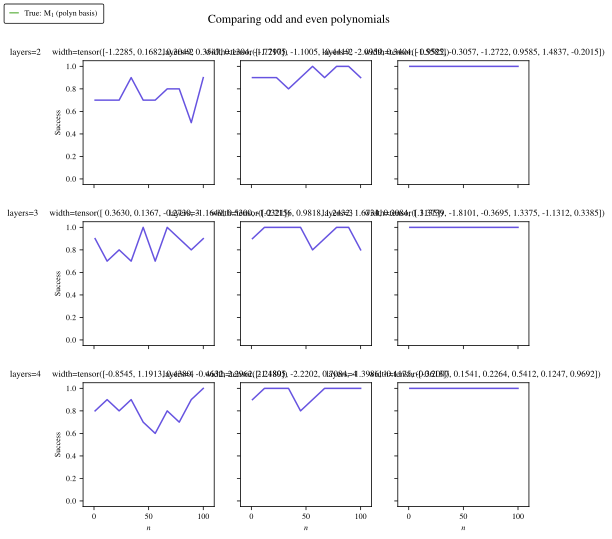

In [9]:
layers = [2, 3, 4]
widths = [5, 10, 50]
d = 5
var = 1
ns = torch.linspace(1, 100, 10)
trials = 10

nrows, ncols = len(layers), len(widths)
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, top=0.9)
fig.suptitle(f'Comparing polynomial and NLM-learned basis')

for i, l in tqdm(enumerate(layers)):
  for j, wdth in enumerate(widths):
    ax = axs[i,j]
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-10, ns[-1]+10)
    ax.set_ylabel('Success')
    ax.set_xlabel('$n$')
    ax.set_xticks(torch.linspace(0, ns[-1], 3))

    layers = [1, *[wdth]*l, 1]
    
    m1 = GaussianRegressionModel(weights_mean=0, weights_var=var, basis_func=poly_basis(d))

    successes = torch.zeros(len(ns))
    for k, n in enumerate(ns):
      n = int(n)
      for _ in range(trials):
        x_train = ds.Uniform(-1.0, 1.0).sample((n,))

        w = m1.sample_model_weights()
        phi_train = m1.basis_func(x_train)
        y_train = add_output_noise(phi_train @ w)
        
        basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
        final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)
        basis.rand_init(var ** 0.5)
        final_layer.rand_init(var ** 0.5)
        (basis, final_layer), loss = train_objective(
            list(basis.parameters()) + list(final_layer.parameters()),
            lambda: mle_loss(basis, final_layer, x_train.reshape(-1, 1), y_train.reshape(-1, 1)),
            lr=LEARNING_RATE,
        )
        basis_ = lambda x: basis(x.reshape(-1, 1))
        m2 = GaussianRegressionModel(weights_mean=0, weights_var=var, basis_func=basis_)

        if bayes_factor(m1, m2, x_train, y_train) >= 1:
          successes[k] += 1
      
    successes /= trials

    ax.set_title(rf'layers={l} \quad width={wdth}')
    ax.plot(ns, successes, c=blues[1])

for row in axs[:-1, 1:]:
  for ax in row:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in axs[:-1, 0]:
  ax.set_xticklabels([])
  ax.set_xlabel('')

for ax in axs[-1, 1:]:
  ax.set_yticklabels([])
  ax.set_ylabel('')


plt.plot([-1], [-1], c=blues[1], label=r'True: $\mathrm M_1$ (polyn basis)')
# plt.plot([-1], [-1], c=blues[1], label=r'True: $\mathrm M_2$ (NLM basis)')
fig.legend(loc='upper left')
fig.savefig(f'output/bases-nlm-2.pdf')
